In [36]:
pip install nltk spacy numpy pandas contractions seaborn tqdm matplotlib wordcloud

Note: you may need to restart the kernel to use updated packages.


In [38]:
import re
import csv
import nltk
import spacy
import numpy as np
import pandas as pd
import contractions
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

Load_Dataset

In [41]:
import zipfile
import os

zip_file = "train_snli.txt.zip"  # Change this to your actual file name

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Extract files into a folder named "dataset"

print("Files extracted successfully!")


Files extracted successfully!


In [43]:
import os
import csv  
from tqdm import tqdm

In [45]:
# ✅ Update the file path based on your extraction location
file_path = "dataset/train_snli.txt"  # Change if the file is in another folder

# ✅ Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}. Check the directory.")

# ✅ Read data from the text file
with open(file_path, 'r', encoding='utf-8') as file:
    data = file.readlines()

# ✅ Prepare CSV file
csv_filename = "data.csv"

with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)
    
    writer.writeheader()
    for line in tqdm(data, desc="Processing Lines"):
        parts = line.strip().split('\t')
        
        # Ensure correct formatting
        if len(parts) != 3:
            print(f"Skipping malformed line: {line.strip()}")
            continue
        
        source_txt = parts[0]
        plagiarism_txt = parts[1]
        
        try:
            label = int(parts[2])
        except ValueError:
            print(f"Skipping line with invalid label: {line.strip()}")
            continue
        
        writer.writerow({
            'source_txt': source_txt,
            'plagiarism_txt': plagiarism_txt,
            'label': label
        })

print("✅ CSV file created successfully: data.csv")


Processing Lines: 100%|█████████████| 367373/367373 [00:01<00:00, 365142.00it/s]

✅ CSV file created successfully: data.csv


In [47]:
df = pd.read_csv("data.csv")
df.sample(5)

,source_txt,plagiarism_txt,label
62971,A man is standing on the passenger side of a b...,one lion running,0
114393,Baseball catcher trying to tag out a player fr...,The catcher is trying to tag a player.,1
358189,A woman with dark hair is holding her baby boy.,A woman is holding a baby girl.,0
67909,Presenters speaking at conference.,cat chases another cat,0
130030,A family sits in the grass in a park in India.,A single person sits in the grass in India.,0


**Shape Of Data**

In [50]:
df.shape

(367373, 3)

****Check Missing Values****

**The given code identifies, removes, and verifies missing values (null values) in a Pandas DataFrame (df) to ensure data quality before further processing.**

In [53]:
# check for null values
print("Null values",df.isnull().sum())
# remove null values
df.dropna(inplace=True)
# check for null values after removing
print("==============================")
print("Null values after removing :",df.isnull().sum())

Null values source_txt        0
plagiarism_txt    4
label             0
dtype: int64
Null values after removing : source_txt        0
plagiarism_txt    0
label             0
dtype: int64


**Checking Duplicate**

**This code checks for and removes duplicate rows in a Pandas DataFrame (df). Removing duplicates is crucial for ensuring data consistency and preventing redundancy in analysis or machine learning models**

In [55]:
# check for duplicates
print("Duplicates",df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)
# check for duplicates after removing
print("==============================")
print("Duplicates after removing :",df.duplicated().sum())

Duplicates 454
Duplicates after removing : 0


**Check Values Count**

**code analyzes and visualizes the distribution of labels (Plagiarized vs. Not Plagiarized) in the dataset using a pie chart.**

**Helps identify imbalanced datasets, which might affect model performance.
Provides a quick visual summary of label distribution.
Assists in deciding if data balancing techniques (e.g., oversampling, undersampling) are needed.**

label
0    183874
1    183041
Name: count, dtype: int64


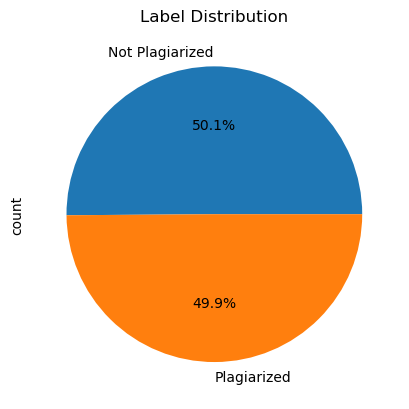

In [58]:
# check value counts
print(df['label'].value_counts())

# Pie Chart
df['label'].value_counts().plot.pie(autopct="%1.1f%%", labels=['Not Plagiarized', 'Plagiarized'])
plt.title('Label Distribution')
plt.show()

**Check Text Length**

**Graph Explanation (Simple Words)
The graph shows two overlapping histograms:
Blue (original text) vs Red (plagiarized text)**

**This helps compare their word count distribution.
Dashed vertical lines show the average length:**

**If the red (plagiarized) line is shorter, it means plagiarized text tends to be shorter than the original.
If they are close together, it means both texts have similar lengths.
The shape of the graph:**

**If both distributions overlap a lot, the plagiarism is almost the same length as the original.**
**If the red curve is more shifted left, plagiarized texts are usually shorter**

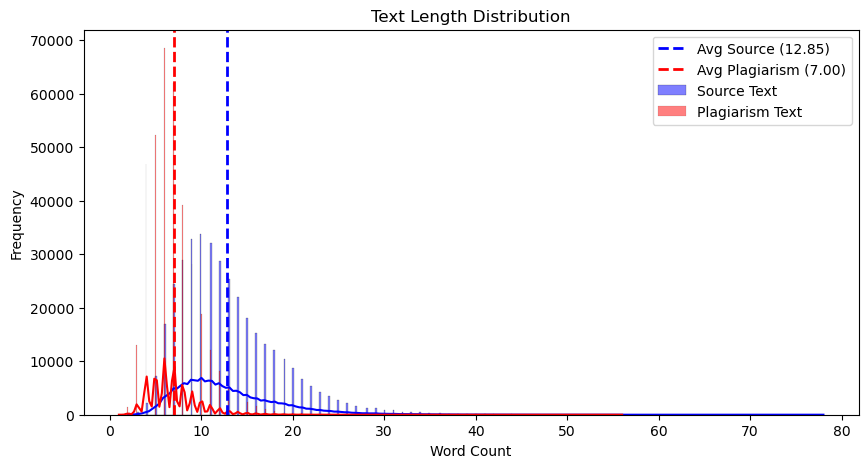

In [61]:
# Calculate source and plagiarism text lengths
df['source_len'] = df['source_txt'].apply(lambda x: len(x.split()))
df['plagiarism_len'] = df['plagiarism_txt'].apply(lambda x: len(x.split()))

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['source_len'], color='blue', label='Source Text', kde=True)
sns.histplot(df['plagiarism_len'], color='red', label='Plagiarism Text', kde=True)

# Calculate averages
avg_source_len = df['source_len'].mean()
avg_plagiarism_len = df['plagiarism_len'].mean()

# Add average lines
plt.axvline(avg_source_len, color='blue', linestyle='dashed', linewidth=2, label=f'Avg Source ({avg_source_len:.2f})')
plt.axvline(avg_plagiarism_len, color='red', linestyle='dashed', linewidth=2, label=f'Avg Plagiarism ({avg_plagiarism_len:.2f})')

# Final touches
plt.title('Text Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The plot shows the text length distribution for source and plagiarized texts. Source texts (blue) are generally longer, averaging 12.85 words, while plagiarized texts (red) are shorter, averaging 7.00 words.

Plagiarized texts are more concentrated around shorter lengths, whereas source texts have a broader distribution. This suggests that plagiarism often involves copying shorter text segments.

**WordCloud**

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

**This code generates and displays two word clouds—one for source (original) text and one for plagiarized text. A word cloud is a visual representation of text where more frequent words appear larger.**

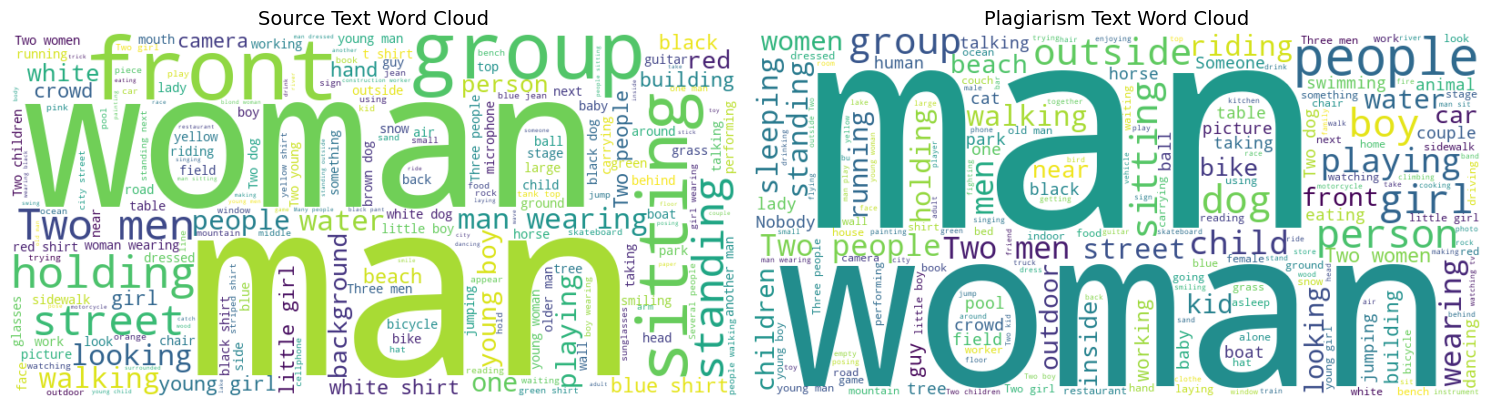

In [68]:
# ✅ Load the dataset (Ensure "data.csv" exists in the working directory)
df = pd.read_csv("data.csv")

# ✅ Check if required columns exist
if 'source_txt' not in df.columns or 'plagiarism_txt' not in df.columns:
    raise ValueError("Error: 'source_txt' or 'plagiarism_txt' column is missing in data.csv")

# ✅ Handle missing values
df = df.dropna(subset=['source_txt', 'plagiarism_txt'])

# ✅ Generate word clouds
source_text = " ".join(df['source_txt'].tolist())
wordcloud_source = WordCloud(width=800, height=400, background_color='white').generate(source_text)

plag_text = " ".join(df['plagiarism_txt'].tolist())
wordcloud_plag = WordCloud(width=800, height=400, background_color='white').generate(plag_text)

# ✅ Plot the word clouds
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(wordcloud_source, interpolation='bilinear')
axes[0].set_title('Source Text Word Cloud', fontsize=14)
axes[0].axis('off')

axes[1].imshow(wordcloud_plag, interpolation='bilinear')
axes[1].set_title('Plagiarism Text Word Cloud', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()


**Preprocessing**
**✅ Cleans and normalizes text by removing unwanted elements (punctuation, numbers, emojis, URLs, etc.)**
**✅ Converts text to lowercase, removes stopwords, and applies lemmatization for better NLP processing**
**✅ Processes two text columns (source_txt and plagiarism_txt) and prepares them for AI-based plagiarism detection**

**This preprocessed text can now be used for machine learning, NLP models, or AI-based plagiarism detection. 🚀**

In [70]:
%%time


# ========== Download Required NLTK Resources ==========
nltk.download('stopwords')

# ========== Load SpaCy Model ==========
nlp = spacy.load('en_core_web_sm')

# ========== Load NLTK Stopwords ==========
stop_words = set(stopwords.words('english'))

# ========== Text Preprocessing Functions ==========
def to_lowercase(text):
    return text.lower() if isinstance(text, str) else ""

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text) if isinstance(text, str) else ""

def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]', '', text) if isinstance(text, str) else ""

def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text) if isinstance(text, str) else ""

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) if isinstance(text, str) else ""

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) if isinstance(text, str) else ""

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip() if isinstance(text, str) else ""

def expand_contractions(text):
    return contractions.fix(text) if isinstance(text, str) else ""

def remove_stopwords(text):
    if isinstance(text, str):
        tokens = text.split()
        return " ".join([word for word in tokens if word not in stop_words])
    return ""

def spacy_tokenization_lemmatization(text):
    if isinstance(text, str):
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc])
    return ""

def remove_specific_words(text, words_to_remove):
    if isinstance(text, str):
        words = text.split()
        return " ".join([word for word in words if word not in words_to_remove])
    return ""

# ========== Full Preprocessing Pipeline ==========
def full_pipeline(text):
    text = to_lowercase(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text
    text = remove_html_tags(text)
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords(text)
    text = spacy_tokenization_lemmatization(text)
    text = remove_specific_words(text, ['chat'])
    return text

# ========== Create Sample DataFrame If Not Defined ==========
try:
    df
except NameError:
    data = {
        'source_txt': ["This is a sample source text!", "Another example with contractions: I'm happy."],
        'plagiarism_txt': ["This is a copied text!", "Same example with some modifications: He is happy."]
    }
    df = pd.DataFrame(data)

# ========== Apply Pipeline ==========
tqdm.pandas(desc="Processing Text")
df['processed_source_txt'] = df['source_txt'].progress_apply(full_pipeline)
df['processed_plagiarism_txt'] = df['plagiarism_txt'].progress_apply(full_pipeline)

# ========== Final Output ==========
print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'processed_plagiarism_txt']])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/satwikojha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing Text: 100%|█████████████████| 367369/367369 [14:58<00:00, 408.91it/s]




========= Final DataFrame =========

                          processed_source_txt  \
0             person horse jump break airplane   
1             person horse jump break airplane   
2                      child smile wave camera   
3                      child smile wave camera   
4        boy jump skateboard middle red bridge   
...                                        ...   
367368       dog blue collar play ball outside   
367369             four dirty barefooted child   
367370             four dirty barefooted child   
367371  man surf bodysuit beautiful blue water   
367372  man surf bodysuit beautiful blue water   

                      processed_plagiarism_txt  
0                  person diner order omelette  
1                        person outdoors horse  
2                                child present  
3                                    kid frown  
4                           boy skate sidewalk  
...                                        ...  
367368           

In [77]:
df.head()

,source_txt,plagiarism_txt,label,processed_source_txt,processed_plagiarism_txt,source_vec,plagiarism_vec
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0,person horse jump break airplane,person diner order omelette,"[-0.85265815, 0.20983513, -0.107485965, 0.8827...","[0.029038463, 1.3271984, 0.47183475, -0.324314..."
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1,person horse jump break airplane,person outdoors horse,"[-0.85265815, 0.20983513, -0.107485965, 0.8827...","[-0.9364812, -0.115481935, -0.031366426, 0.963..."
2,Children smiling and waving at camera,There are children present,1,child smile wave camera,child present,"[0.18743868, 0.27242276, -0.10323511, 0.093398...","[0.14279938, 1.6067351, 0.23945524, -0.2425022..."
3,Children smiling and waving at camera,The kids are frowning,0,child smile wave camera,kid frown,"[0.18743868, 0.27242276, -0.10323511, 0.093398...","[-0.1280517, 1.1117139, 0.046471834, 0.7200196..."
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0,boy jump skateboard middle red bridge,boy skate sidewalk,"[0.0808365, -0.028255204, 0.61969614, 0.733564...","[0.12074283, 0.19258559, 1.0145872, 0.6233597,..."


**ML (RandomForest)**

In [31]:
!pip install tensorflow

In [33]:
# ========== Required Libraries for ML Model==========
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ========== Prepare X and y ==========
# Combine source_vec and plagiarism_vec to form feature set
X = np.vstack([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
y = df['label'].values

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Train RandomForest Model ==========
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ========== Make Predictions ==========
y_pred = clf.predict(X_test)

# ========== Evaluate Model ==========
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n\n========= Model Evaluation =========\n")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)



========= Model Evaluation =========

Accuracy: 47.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.55      0.50        49
           1       0.48      0.39      0.43        51

    accuracy                           0.47       100
   macro avg       0.47      0.47      0.47       100
weighted avg       0.47      0.47      0.47       100



**DL (LSTM with keras tuner)**

In [35]:
!pip install keras-tuner
import pandas as pd  

# Sample DataFrame Structure  
data = {
    'source_vec': [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]],  
    'plagiarism_vec': [[0.2, 0.3, 0.4], [0.5, 0.6, 0.7], [0.8, 0.9, 1.0]],  
    'label': [0, 1, 0]  
}  

df = pd.DataFrame(data)  
print(df)  


        source_vec   plagiarism_vec  label
0  [0.1, 0.2, 0.3]  [0.2, 0.3, 0.4]      0
1  [0.4, 0.5, 0.6]  [0.5, 0.6, 0.7]      1
2  [0.7, 0.8, 0.9]  [0.8, 0.9, 1.0]      0


In [39]:
%%time

# ========== Required Libraries for LSTM Model ==========
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# ========== Prepare X and y ==========
# Combine source_vec and plagiarism_vec to form feature set
X = np.array([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
y = np.array(df['label'].values)

# ========== Reshape Data for LSTM ==========
# LSTM requires 3D input: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Early Stopping Callback ==========
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ========== Hyperparameter Tuning with Keras Tuner ==========
def build_model(hp):
    model = Sequential()

    # ========== Number of LSTM Layers ==========
    # Tune the number of LSTM layers (1 to 3 layers)
    num_layers = hp.Int('num_lstm_layers', min_value=1, max_value=6, step=1)
    
    for i in range(num_layers):
        # LSTM Layer with hyperparameter tuning for units
        model.add(LSTM(
            units=hp.Int(f'lstm_units_{i+1}', min_value=32, max_value=128, step=32),
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=True if i < num_layers - 1 else False)
        )
        
        # Dropout Layer with hyperparameter tuning for rate
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i+1}', min_value=0.2, max_value=0.5, step=0.1)))

    # ========== Dense Layer ==========
    # Dense layer with hyperparameter tuning for units and activation function
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])
    ))
    
    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # ========== Optimizer and Learning Rate ==========
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer == 'adam':
        optim = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    else:
        optim = tf.keras.optimizers.RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    
    # Compile the model
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# ========== Initialize the Hyperparameter Tuner ==========
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='keras_tuner',
    project_name='lstm_layers_tuning'
)

# ========== Search for the Best Hyperparameters ==========
tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# ========== Get the Best Hyperparameters ==========
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"\n\nBest Hyperparameters: \n{best_hyperparameters.values}")

# ========== Build and Train the Best Model ==========
best_model = tuner.hypermodel.build(best_hyperparameters)
history = best_model.fit(X_train, y_train, initial_epoch=5, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# ========== Evaluate the Best Model ==========
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\n\nBest Model Accuracy: {accuracy * 100:.2f}%")

# ========== Make Predictions ==========
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# ========== Display Classification Report ==========
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Reloading Tuner from keras_tuner/lstm_layers_tuning/tuner0.json


Best Hyperparameters: 
{'num_lstm_layers': 1, 'lstm_units_1': 128, 'dropout_rate_1': 0.2, 'dense_units': 128, 'dense_activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.00017125587605581677, 'lstm_units_2': 32, 'dropout_rate_2': 0.30000000000000004, 'lstm_units_3': 96, 'dropout_rate_3': 0.4, 'lstm_units_4': 96, 'dropout_rate_4': 0.2, 'lstm_units_5': 32, 'dropout_rate_5': 0.2, 'lstm_units_6': 64, 'dropout_rate_6': 0.2, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 6/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - accuracy: 0.5000 - loss: 0.6912 - val_accuracy: 1.0000 - val_loss: 0.6877
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5000 - loss: 0.6929 - val_accuracy: 1.0000 - val_loss: 0.6868
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5000 - loss: 0.6955 - val_accuracy: 1.0000 - val_loss: 0.6882
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5000 - loss: 0.6858 - val_accuracy: 1.0000 - val_loss: 0.6885
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.6898 - val_accuracy: 1.0000 - val_loss: 0.6871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.6868


Best Model Accuracy: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1


**History plot**

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.5000 - loss: 0.7266 - val_accuracy: 0.0000e+00 - val_loss: 0.7509
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5000 - loss: 0.7177 - val_accuracy: 0.0000e+00 - val_loss: 0.7401
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5000 - loss: 0.7101 - val_accuracy: 0.0000e+00 - val_loss: 0.7298
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5000 - loss: 0.7032 - val_accuracy: 0.0000e+00 - val_loss: 0.7206
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5000 - loss: 0.6970 - val_accuracy: 0.0000e+00 - val_loss: 0.7118
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5000 - loss: 0.6916 - val_accuracy: 0.0000e+00 - val_loss: 0.7031
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.6890 - val_accuracy: 0.0000e+00 - val_loss: 0.6959
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5000 - loss: 0.6864 - val_accuracy: 1.0000 -

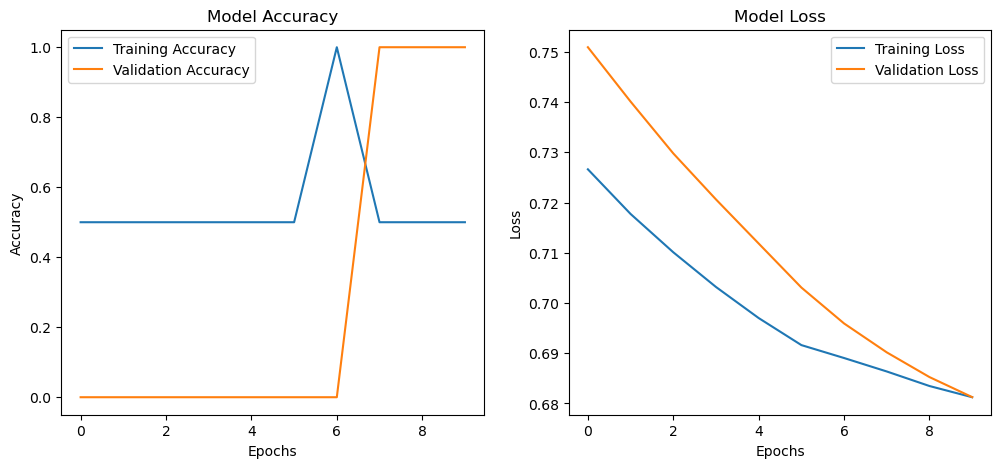

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# ✅ Reshape X_train and X_test
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten input
X_test = X_test.reshape(X_test.shape[0], -1)

# ✅ Define Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 🔥 Train the model and store the history
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# ✅ Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Save the data 

In [67]:
import pickle
from gensim.models import Word2Vec

# Create a Word2Vec model (this could be any model)
sentences = [['hello', 'world'], ['word', 'embedding']]  # Example data
model = Word2Vec(sentences, min_count=1)

# Save the model to a .pkl file
with open('word2vec_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Confirmation message
print("Model is saved.")


Model is saved.
